In [6]:
!pip install pydub --quiet

In [7]:
import numpy as np
import os
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from pydub import AudioSegment
from scipy.fftpack import dct
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def mfcc_from_scratch(signal, sample_rate, num_ceps=13, pre_emphasis=0.97, frame_size=0.025, frame_stride=0.01, NFFT=512, nfilt=26):
    """
    Extract MFCC features from an audio signal (from scratch).
    
    Parameters:
        signal (np.array): Audio signal.
        sample_rate (int): Sampling rate.
        num_ceps (int): Number of cepstral coefficients to return.
        pre_emphasis (float): Pre-emphasis filter coefficient.
        frame_size (float): Frame size in seconds.
        frame_stride (float): Frame stride in seconds.
        NFFT (int): FFT size.
        nfilt (int): Number of Mel filters.
        
    Returns:
        np.array: MFCC feature matrix.
    """
    # Pre-Emphasis
    emphasized = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    
    # Framing
    frame_length = int(round(frame_size * sample_rate))
    frame_step = int(round(frame_stride * sample_rate))
    signal_length = len(emphasized)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
    
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized, z)
    
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
              np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    # Windowing using Hamming window
    frames *= np.hamming(frame_length)
    
    # Fourier-Transform and Power Spectrum
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * (mag_frames ** 2))  # Power Spectrum
    
    # Mel Filterbank
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
        
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)
    
    # Discrete Cosine Transform to get MFCCs
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, :num_ceps]
    
    return mfcc

In [11]:
from pydub import AudioSegment
from pydub.utils import mediainfo

base_path = '/kaggle/input/audio-dataset-with-10-indian-languages/Language Detection Dataset'
languages = ['Hindi', 'Tamil', 'Bengali']

data = []
labels = []

def read_mp3(file_path):
    audio = AudioSegment.from_file(file_path, format="mp3")
    samples = np.array(audio.get_array_of_samples()).astype(np.float32)
    sr = audio.frame_rate
    if audio.channels == 2:
        samples = samples[::2]  # take one channel if stereo
    return sr, samples

for lang in languages:
    lang_dir = os.path.join(base_path, lang)
    if not os.path.exists(lang_dir):
        print(f"Directory not found: {lang_dir}")
        continue
    files_in_lang = [f for f in os.listdir(lang_dir) if f.lower().endswith('.mp3')]
    for file in files_in_lang[:50]:  
        file_path = os.path.join(lang_dir, file)
        try:
            sample_rate, signal = read_mp3(file_path)
            if len(signal) > sample_rate * 3:
                signal = signal[:sample_rate * 3]  
            mfcc_feat = mfcc_from_scratch(signal, sample_rate)
            mfcc_mean = np.mean(mfcc_feat, axis=0)
            data.append(mfcc_mean)
            labels.append(lang)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

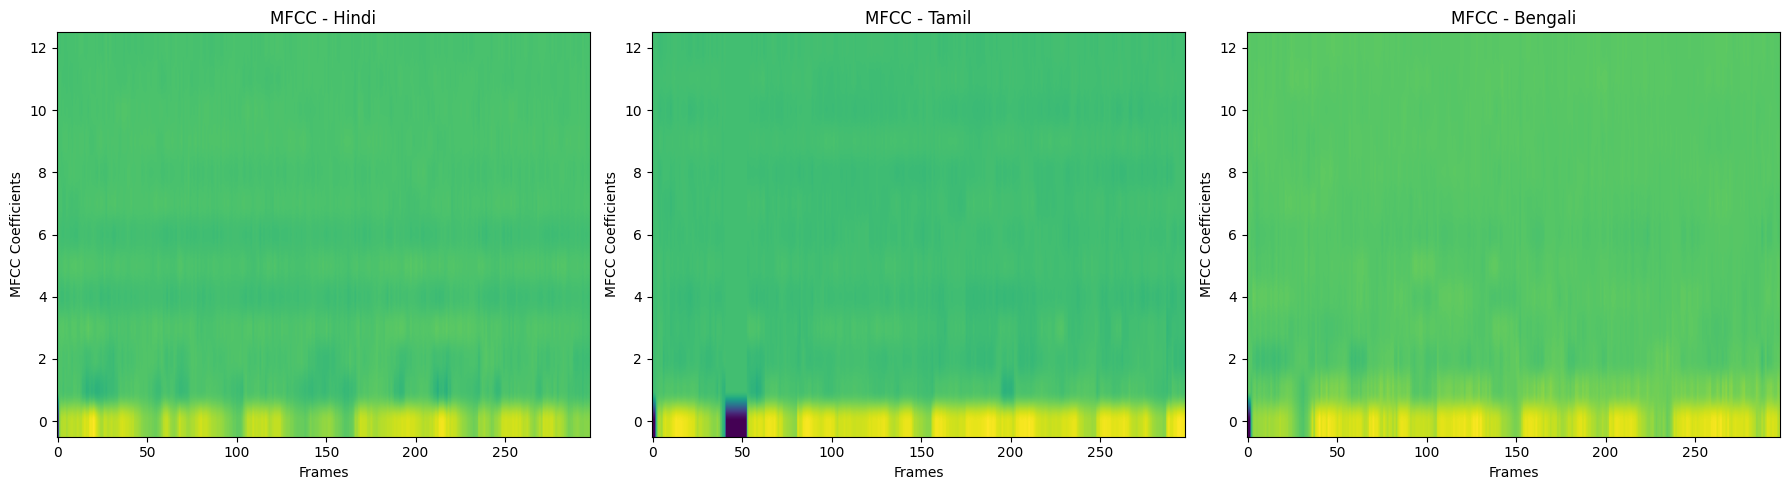

In [12]:
plt.figure(figsize=(18, 5))
for i, lang in enumerate(languages):
    lang_dir = os.path.join(base_path, lang)
    if not os.path.exists(lang_dir):
        continue
    sample_file = os.path.join(lang_dir, os.listdir(lang_dir)[0])
    try:
        sr, sig = read_mp3(sample_file)
        if len(sig) > sr * 3:
            sig = sig[:sr * 3]
        mfcc_feat = mfcc_from_scratch(sig, sr)
        plt.subplot(1, 3, i + 1)
        plt.imshow(mfcc_feat.T, aspect='auto', origin='lower')
        plt.title(f'MFCC - {lang}')
        plt.xlabel('Frames')
        plt.ylabel('MFCC Coefficients')
    except Exception as e:
        print(f"Error processing visualization for {sample_file}: {e}")
        continue
plt.tight_layout()
plt.show()

Mean MFCC Values by Language:
                  0          1          2          3          4          5  \
label                                                                        
Bengali  310.207853  33.943248 -19.319977  17.342866 -15.734893   7.170230   
Hindi    336.880980  -6.207529 -23.437861  30.265647 -22.956803  16.759900   
Tamil    452.290300  38.934792 -13.874696  12.432918 -17.042667  11.251234   

                 6         7          8         9         10        11  \
label                                                                    
Bengali -15.527510  0.621398  -3.032256 -1.921211  -5.331950 -0.507212   
Hindi   -16.419757 -0.034092  -4.556852 -2.398783  -1.555057 -0.920268   
Tamil   -20.390667 -6.247601 -14.208085  4.027612 -14.113141  2.343534   

               12  
label              
Bengali -0.357213  
Hindi   -1.134979  
Tamil   -3.115463  

Variance of MFCC Values by Language:
                   0           1           2           3           4  

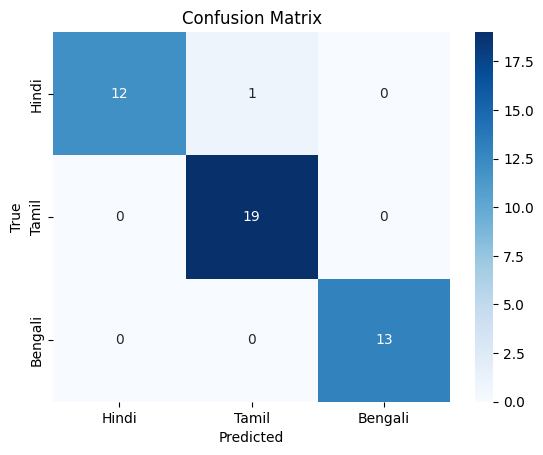

In [13]:
# --- Bonus: Statistical Analysis of MFCCs ---
df = pd.DataFrame(data)
df['label'] = labels
mean_df = df.groupby('label').mean()
var_df = df.groupby('label').var()
print("Mean MFCC Values by Language:")
print(mean_df)
print("\nVariance of MFCC Values by Language:")
print(var_df)

X = np.array(data)
y = np.array(labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, xticklabels=languages, yticklabels=languages, cmap='Blues', fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()